<a href="https://colab.research.google.com/github/Tushar-Shinde31/Sentiment-Analysis-on-X-Twitter-Data-Using-NLP-and-Machine-Learnin/blob/main/X(Twitter).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import nltk
import string
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Load the dataset
file_path = "/content/drive/MyDrive/Data_Science_Internship_Mat/X data.csv"  # Update with your dataset path
tweet_file = pd.read_csv(file_path)

# Check for necessary columns
if 'clean_text' not in tweet_file.columns or 'category' not in tweet_file.columns:
    raise ValueError("Dataset must contain 'clean_text' and 'category' columns.")

# Display first few rows for verification
print(tweet_file.head())


                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0


In [ ]:
# Initialize tokenizer and stopwords
tknzr = TweetTokenizer()
stop_words = set(stopwords.words("english"))

# Define preprocessing function
def preprocess_text(text):
    tokens = tknzr.tokenize(str(text).lower())  # Tokenize and convert to lowercase
    tokens = [word for word in tokens if word not in string.punctuation and
              word not in stop_words and '@' not in word]  # Remove stopwords, punctuation, mentions
    return " ".join(tokens)  # Rejoin tokens into a single string

# Apply the cleaning function
tweet_file['clean_data'] = tweet_file['clean_text'].apply(preprocess_text)

# Verify the cleaned data
print(tweet_file[['clean_text', 'clean_data']].head())


                                          clean_text  \
0  when modi promised “minimum government maximum...   
1  talk all the nonsense and continue all the dra...   
2  what did just say vote for modi  welcome bjp t...   
3  asking his supporters prefix chowkidar their n...   
4  answer who among these the most powerful world...   

                                          clean_data  
0  modi promised “ minimum government maximum gov...  
1             talk nonsense continue drama vote modi  
2  say vote modi welcome bjp told rahul main camp...  
3  asking supporters prefix chowkidar names modi ...  
4  answer among powerful world leader today trump...  


In [ ]:
# Split the dataset into training (80%) and testing (20%) sets
train_data = tweet_file.sample(frac=0.8, random_state=42)
test_data = tweet_file.drop(train_data.index)

# Verify the split
print(f"Training samples: {len(train_data)}, Testing samples: {len(test_data)}")


Training samples: 130384, Testing samples: 32596


In [ ]:
# Initialize VADER Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

# Define a function for sentiment labeling
def get_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score >= 0.05:
        return "pos"
    elif score <= -0.05:
        return "neg"
    else:
        return "neu"

# Apply VADER sentiment analysis
train_data['sentiment'] = train_data['clean_data'].apply(get_sentiment)
test_data['sentiment'] = test_data['clean_data'].apply(get_sentiment)

# Save processed data for future reference
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)


In [ ]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, use_idf=True)

# Fit the vectorizer on training data and transform both training and testing data
train_vectors = vectorizer.fit_transform(train_data['clean_data'].values.astype('U'))
test_vectors = vectorizer.transform(test_data['clean_data'].values.astype('U'))


In [ ]:
# Initialize SVM with a linear kernel
classifier = svm.SVC(kernel='linear')

# Train the classifier
classifier.fit(train_vectors, train_data['sentiment'])
print("Model training complete.")


Model training complete.


In [ ]:
# Predict on test data
predictions = classifier.predict(test_vectors)

# Evaluate the model
print("Classification Report:")
print(classification_report(test_data['sentiment'], predictions))


Classification Report:
              precision    recall  f1-score   support

         neg       0.89      0.85      0.87      9885
         neu       0.90      0.92      0.91      7150
         pos       0.91      0.93      0.92     15561

    accuracy                           0.90     32596
   macro avg       0.90      0.90      0.90     32596
weighted avg       0.90      0.90      0.90     32596



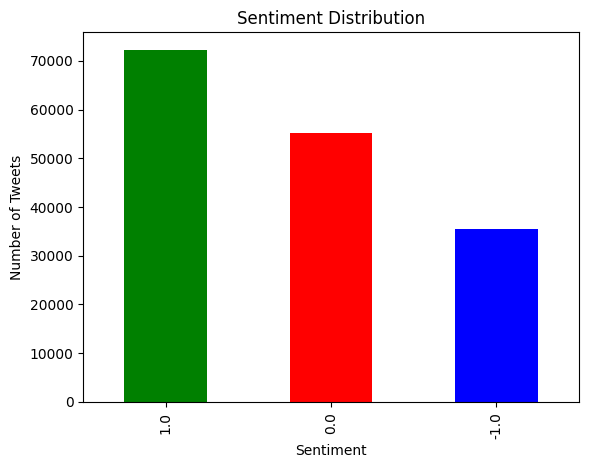

In [ ]:
import matplotlib.pyplot as plt

# Plot sentiment distribution in the dataset
sentiment_counts = tweet_file['category'].value_counts()
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()


In [ ]:
import joblib

# Save the trained SVM model
joblib.dump(classifier, "svm_sentiment_model.pkl")

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("Model and vectorizer saved successfully!")


Model and vectorizer saved successfully!


In [ ]:
# Load the trained SVM model
loaded_model = joblib.load("svm_sentiment_model.pkl")

# Load the TF-IDF vectorizer
loaded_vectorizer = joblib.load("tfidf_vectorizer.pkl")

print("Model and vectorizer loaded successfully!")


Model and vectorizer loaded successfully!


In [ ]:
# Example input for prediction
new_text = ["I love this product!", "This is the worst experience ever."]

# Preprocess the text
new_text_cleaned = [preprocess_text(text) for text in new_text]

# Transform the text using the loaded vectorizer
new_text_vectors = loaded_vectorizer.transform(new_text_cleaned)

# Predict sentiment
predictions = loaded_model.predict(new_text_vectors)

print("Predictions:", predictions)


Predictions: ['pos' 'neg']
